In [1]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
import time

from hawkes_discret.kernels import KernelExpDiscret,\
KernelRaisedCosineDiscret

from hawkes_discret.hawkes_discret_l2 import HawkesDiscretL2
from hawkes_discret.utils.utils import projected_grid

import pickle
import matplotlib 
kernel_model = 'RaisedCosine'
from hawkes_discret.utils.utils import optimizer, projected_grid, init_kernel
from hawkes_discret.loss_and_gradient import l2loss_precomputation, l2loss_conv
from hawkes_discret.loss_and_gradient import get_grad_mu, get_grad_alpha, get_grad_theta
from hawkes_discret.utils.compute_constants_np import get_zG, get_zN, get_ztzG
from tick.hawkes import SimuHawkes,  HawkesKernelTimeFunc

/data/parietal/store/work/gstaerma/miniconda3/lib/python3.9/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
2022-09-13 19:21:45.018828: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-13 19:21:45.018853: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
file_name = "benchmark.pkl"
open_file = open(file_name, "rb")
all_results = pickle.load(open_file)
open_file.close()

file_name = "benchmark2.pkl"
open_file = open(file_name, "rb")
all_results_ = pickle.load(open_file)
open_file.close()

file_name = "benchmark3.pkl"
open_file = open(file_name, "rb")
all_results__ = pickle.load(open_file)
open_file.close()

In [3]:
def get_results(results, n_seeds, n_dt):
    baseline = np.array([1.1]); alpha = np.array([[0.8]]); 
    mu = np.array([[0.5]]); sigma = np.array([[0.3]]); u = mu - sigma

    mu_vis = np.zeros((n_seeds, n_dt))
    alpha_vis = np.zeros((n_seeds, n_dt))
    u_vis = np.zeros((n_seeds, n_dt))
    sigma_vis = np.zeros((n_seeds, n_dt))
    loss_vis = np.zeros((n_seeds, n_dt))
    comptime_vis = np.zeros((n_seeds, n_dt))
    for i in range(n_seeds):
        for j in range(n_dt):
            idx = j*n_seeds + i
            mu_vis[i, j] = np.abs(results[idx]['param_baseline'][-1] - baseline)
            alpha_vis[i, j] = np.abs(results[idx]['param_adjacency'][-1] - alpha)
            u_vis[i, j] = np.abs(results[idx]['param_u'][-1] - u)
            sigma_vis[i, j] = np.abs(results[idx]['param_sigma'][-1] - sigma)
            loss_vis[i, j] = results[idx]['v_loss'][-1]
            comptime_vis[i, j] = results[idx]['time']
    return [mu_vis, alpha_vis, u_vis, sigma_vis, loss_vis, comptime_vis]


def plot_one_curve(axs, data, title, dt_list, i, j, col, T):   
    lw = 2
    fontsize = 18
    if (i == 2 and j == 0):
        axs[2, 0].plot(dt_list, data.mean(0), lw=lw, label='T={}'.format(T),  c=col)
    else:
        axs[i, j].semilogy(dt_list, data.mean(0), lw=lw,  label='T={}'.format(T),  c=col)
    #axs[0, 0].axhline(y = baseline, color = 'k', linestyle = ':')
    axs[i, j].set_title(title, size=fontsize)
    axs[i, j].fill_between(dt_list, np.percentile(data, 10, axis=0), 
                        np.percentile(data, 90, axis=0), alpha=0.1, color=col)
    axs[i, j].set_xlim(dt_list[-1], dt_list[0])
    axs[i, j].set_xlabel('dt', size=fontsize)
    axs[i, j].invert_xaxis()
    axs[i, j].legend(fontsize=20)
    axs[i, j].set_xticks(dt_list)
    axs[i, j].set_xscale('log')
    return 0;

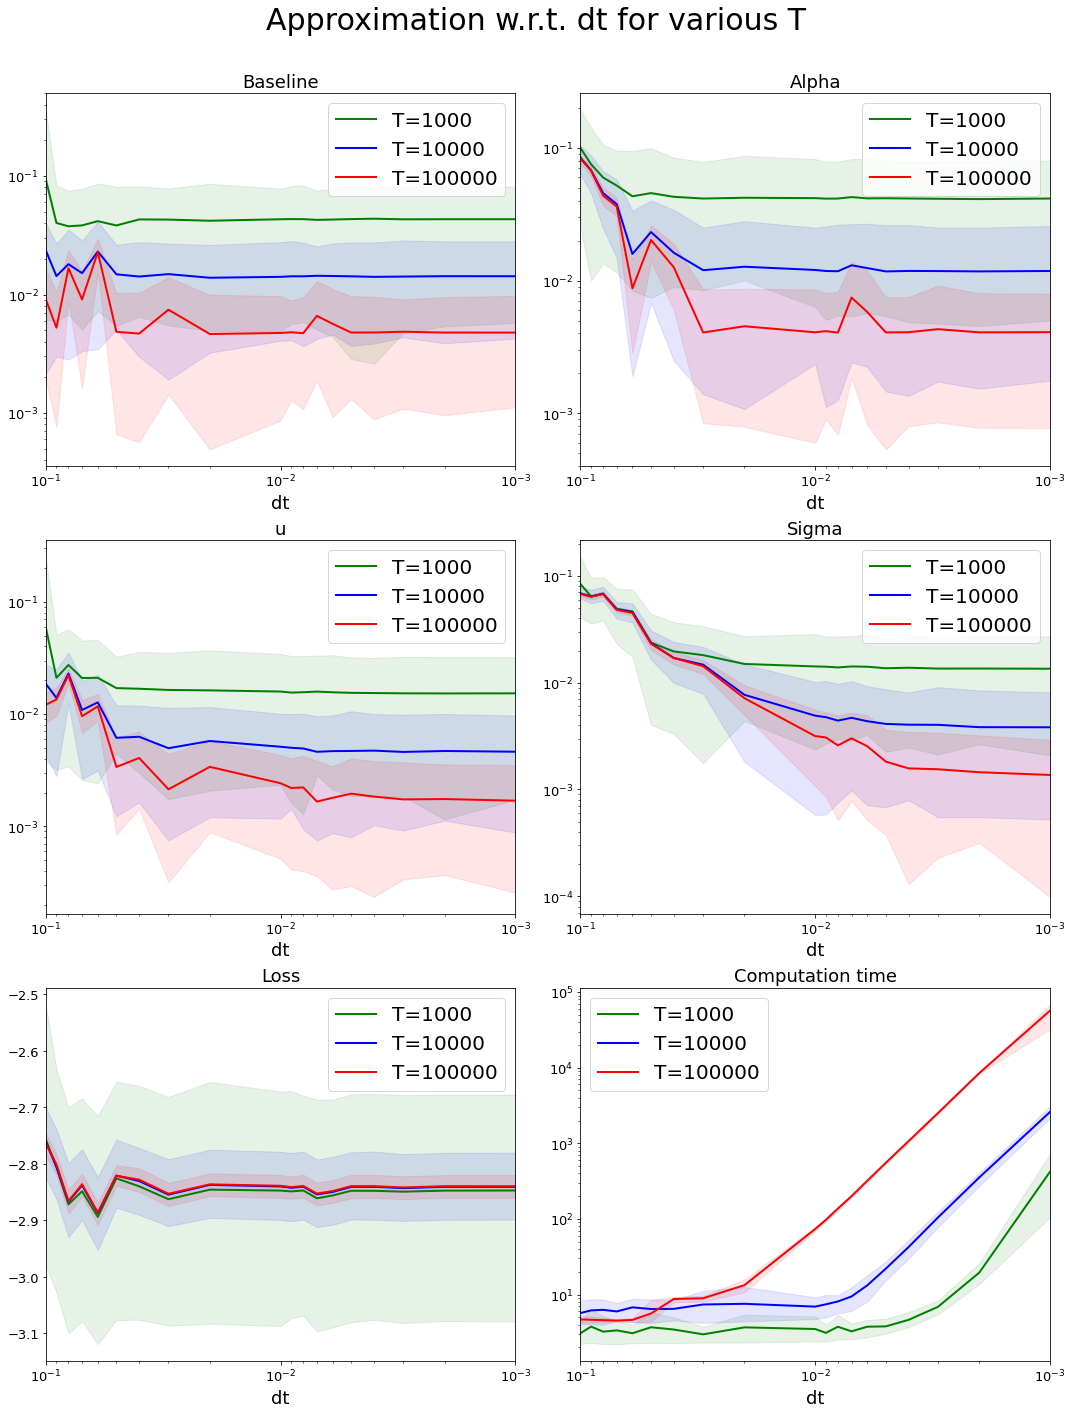

In [4]:
T_list = [10000]
dt_list = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02,  
0.01, 0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002, 0.001 ]
seeds = np.arange(100)
n_T = len(T_list)
n_dt = len(dt_list) 
n_seeds = len(seeds)
n_xp = len(all_results)


data = get_results(all_results,  n_seeds, n_dt)
data_ = get_results(all_results_,  n_seeds, n_dt)
data__ = get_results(all_results__,  n_seeds, n_dt)
titles = ['Baseline', 'Alpha', 'u', 'Sigma', 'Loss', 'Computation time']
# %% plot loss
%matplotlib inline
matplotlib.rc("xtick", labelsize=13)
matplotlib.rc("ytick", labelsize=13)

fig, axs = plt.subplots(3, 2, figsize=(15, 20))
fig.suptitle('Approximation w.r.t. dt for various T', fontsize=30)

for i in range(3):
    for j in range(2):
        idx = i*2+j
        plot_one_curve(axs, data__[idx], titles[idx], dt_list, i, j, 'g', 1000)
        plot_one_curve(axs, data[idx], titles[idx], dt_list, i, j, 'b', 10000)
        plot_one_curve(axs, data_[idx], titles[idx], dt_list, i, j, 'r', 100000)
        

fig.tight_layout()
fig.subplots_adjust(top=0.92)
fig.savefig('results/approx.pdf')


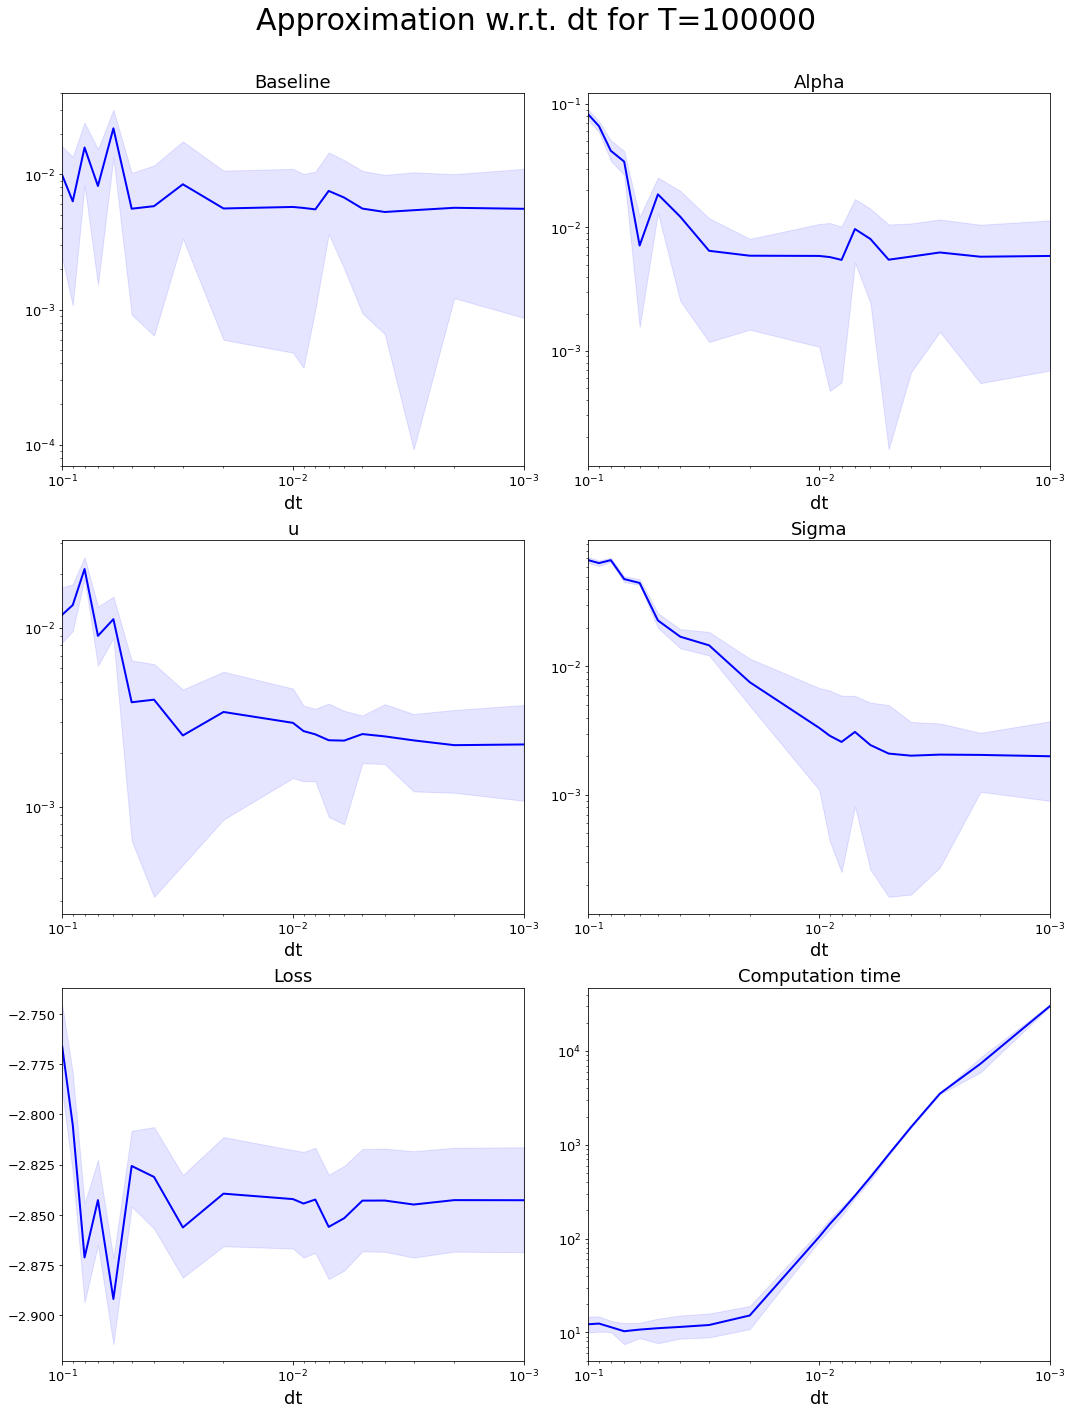

In [14]:
T_list = [100000]
dt_list = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02,  
0.01, 0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002, 0.001]
seeds = np.arange(10)
n_T = len(T_list)
n_dt = len(dt_list) 
n_seeds = len(seeds)
n_xp = len(all_results)

data_ = get_results(all_results_,  n_seeds, n_dt)
titles = ['Baseline', 'Alpha', 'u', 'Sigma', 'Loss', 'Computation time']

%matplotlib inline
matplotlib.rc("xtick", labelsize=13)
matplotlib.rc("ytick", labelsize=13)

fig, axs = plt.subplots(3, 2, figsize=(15, 20))
fig.suptitle('Approximation w.r.t. dt for T={}'.format(T_list[0]), fontsize=30)

for i in range(3):
    for j in range(2):
        idx = i*2+j
        plot_one_curve(axs, data_[idx], titles[idx], dt_list, i, j)

fig.tight_layout()
fig.subplots_adjust(top=0.92)
fig.savefig('results/T_100000_s_10.pdf')

## True parameters

In [3]:
baseline = torch.tensor([1., 1.5], dtype=torch.float64)
mu = torch.tensor([[0.5, 0.5],[0.6, 0.5]], dtype=torch.float64)
sigma = torch.tensor([[0.4, 0.4],[0.3, 0.3]], dtype=torch.float64)
# adjacency = torch.tensor([[0.2, 0.3],[0.15, 0.2]], dtype=torch.float64)
adjacency = torch.tensor([[1, 0.],[0., 2]], dtype=torch.float64)
u = (mu.clone() - sigma.clone())
dt = 0.01
T = 100000
L = int(1/dt)
discretization = torch.linspace(0, 1, L)


In [34]:
RC = KernelRaisedCosineDiscret(dt)

baseline = torch.tensor([1.1])
alpha = torch.tensor([[0.4]])
mu = torch.tensor([[0.5]])
sigma = torch.tensor([[0.3]])
u = (mu.clone() - sigma.clone())

kernel_values = RC.eval(u, sigma, discretization) #* dt
kernel_values = kernel_values * alpha[:, :, None]

t_values = discretization.double().numpy()
k = kernel_values[0, 0].double().numpy()

tf = HawkesKernelTimeFunc(t_values=t_values, y_values=k)
kernels = [[tf]]

hawkes = SimuHawkes(baseline=[1.1], kernels=kernels, end_time=T,
                    verbose=False, seed=0)

hawkes.simulate()
events = hawkes.timestamps

In [42]:
size_grid = L * T + 1
n_dim = len(events)
discretization = torch.linspace(0, 1, int(1 / dt))

events_grid = projected_grid(
    events, dt, size_grid)
n_events = events_grid.sum(1)

zG, _ = get_zG(events_grid.numpy(), L)
zN, _ = get_zN(events_grid.numpy(), L)
ztzG, _ = get_ztzG(events_grid.numpy(), L)
zG = torch.tensor(zG).float()
zN = torch.tensor(zN).float()
ztzG = torch.tensor(ztzG).float()


l2 = l2loss_precomputation(zG, zN, ztzG, baseline,
                                              alpha,
                                              kernel_values, n_events,
                                              dt,
                                              T)
print(l2)

RC = KernelRaisedCosineDiscret(dt)

baseline = torch.tensor([1.1])
alpha_ = torch.tensor([[0.4]]) * 1.2
mu = torch.tensor([[0.5]])
sigma_ = torch.tensor([[0.3]]) * 1.2
#alpha *= 1.2
#sigma /= 1.2

u = (mu.clone() - sigma.clone())

kernel_values_ = RC.eval(u, sigma_, discretization) #* dt
kernel_values_ = kernel_values_ * alpha_[:, :, None]

l2 = l2loss_precomputation(zG, zN, ztzG, baseline,
                                              alpha_,
                                              kernel_values_, n_events,
                                              dt,
                                              T)
print(l2)                                              

tensor(-2.0357)
tensor(-2.1423)


In [4]:
max_iter = 2000
n_dim = 2


file_name = "test1.pkl"
open_file = open(file_name, "rb")
results_1 = pickle.load(open_file)
open_file.close()



## First example

In [5]:
loss = results_1[0]
grad_baseline = results_1[1]
grad_adjacency = results_1[2]
grad_u = results_1[3]
grad_sigma = results_1[4]
param_baseline_e = torch.abs(results_1[5])# - baseline)
param_adjacency_e = torch.abs(results_1[6])# - adjacency)
param_u_e = torch.abs(results_1[7])# - u)
param_sigma_e = torch.abs(results_1[8])# - sigma)
epochs = torch.arange(max_iter)
epochss = torch.arange(max_iter+1)

Text(0.5, 1.0, 'Loss')

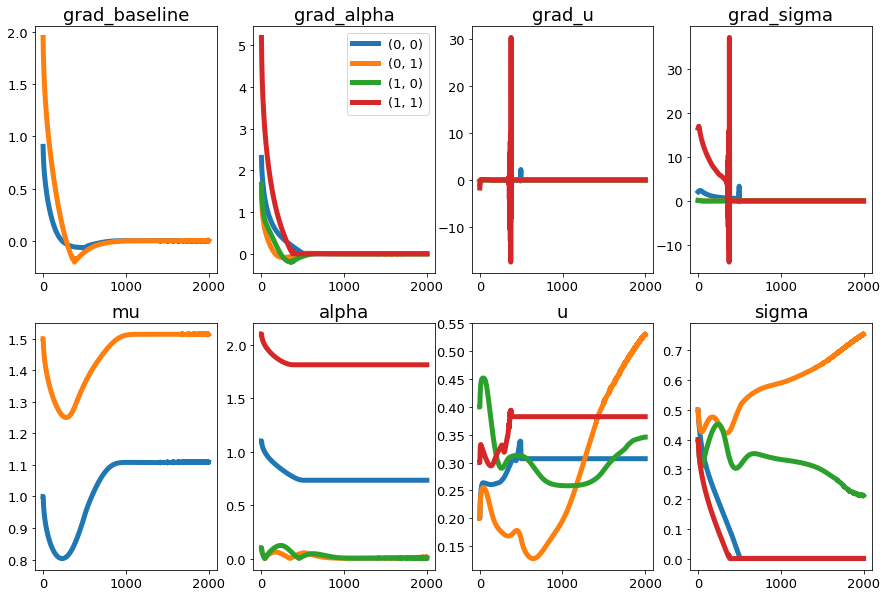

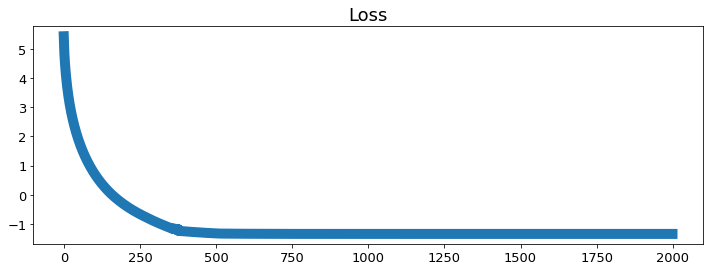

In [8]:
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 
lw = 5
fontsize = 18
fig, axs = plt.subplots(2,4, figsize=(15, 10))

for i in range(n_dim):
    axs[0, 0].plot(epochs, grad_baseline[:, i], lw=lw)
    axs[0, 0].set_title('grad_baseline', size=fontsize)
    
    axs[1, 0].plot(epochss, param_baseline_e[:, i], lw=lw)
    axs[1, 0].set_title('mu', size=fontsize)

    for j in range(n_dim):
        axs[0, 1].plot(epochs, grad_adjacency[:, i, j], lw=lw, label=(i, j))
        axs[0, 1].set_title('grad_alpha', size=fontsize)
        axs[0, 1].legend(fontsize=fontsize-5)
        
        axs[0, 2].plot(epochs, grad_u[:, i, j], lw=lw)
        axs[0, 2].set_title('grad_u', size=fontsize)
        
        axs[0, 3].plot(epochs, grad_sigma[:, i, j], lw=lw)
        axs[0, 3].set_title('grad_sigma', size=fontsize)
        
        axs[1, 1].plot(epochss, param_adjacency_e[:, i, j], lw=lw)
        axs[1, 1].set_title('alpha', size=fontsize)

        axs[1, 2].plot(epochss, param_u_e[:, i, j], lw=lw)
        axs[1, 2].set_title('u', size=fontsize)

        axs[1, 3].plot(epochss, param_sigma_e[:, i, j], lw=lw)
        axs[1, 3].set_title('sigma', size=fontsize)
        
plt.figure(figsize=(12,4))

plt.tight_layout()
plt.plot(epochs, loss, lw=10)
plt.title('Loss', size=fontsize)

## Second example

In [50]:
max_iter = 1000
n_dim = 1

file_name = "test2.pkl"
open_file = open(file_name, "rb")
results_2 = pickle.load(open_file)
open_file.close()

baseline = torch.tensor([1.1], dtype=torch.float64)
alpha = torch.tensor([[0.4]], dtype=torch.float64)
mu = torch.tensor([[0.5]], dtype=torch.float64)
sigma = torch.tensor([[0.3]], dtype=torch.float64)
u = (mu.clone() - sigma.clone())

In [51]:
loss = results_2[0]
grad_baseline = results_2[1]
grad_adjacency = results_2[2]
grad_u = results_2[3]
grad_sigma = results_2[4]
param_baseline_e = torch.abs(results_2[5])# - baseline)
param_adjacency_e = torch.abs(results_2[6])*2*results_2[8]# - adjacency)
param_u_e = torch.abs(results_2[7])# - u)
param_sigma_e = torch.abs(results_2[8])# - sigma)
epochs = torch.arange(max_iter)
epochss = torch.arange(max_iter+1)

Text(0.5, 1.0, 'Loss')

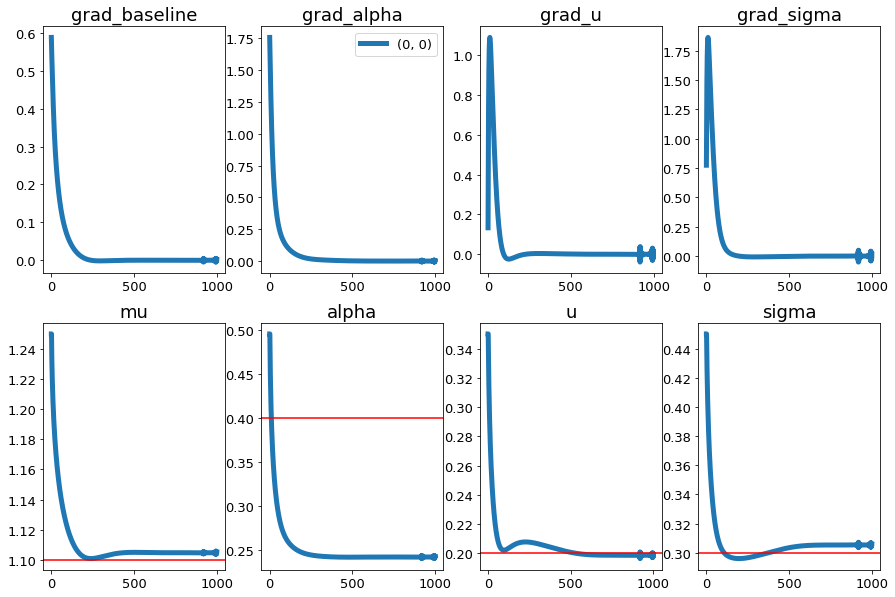

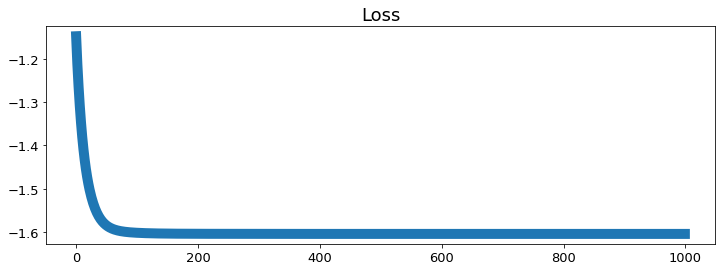

In [52]:
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 
lw = 5
fontsize = 18
n_dim=1
fig, axs = plt.subplots(2,4, figsize=(15, 10))

for i in range(n_dim):
    axs[0, 0].plot(epochs, grad_baseline, lw=lw)
    axs[0, 0].set_title('grad_baseline', size=fontsize)
    
    axs[1, 0].plot(epochss, param_baseline_e, lw=lw)
    axs[1, 0].set_title('mu', size=fontsize)
    axs[1, 0].axhline(y = baseline.numpy(), color = 'r', linestyle = '-')
    for j in range(n_dim):
        axs[0, 1].plot(epochs, grad_adjacency[:, i, j], lw=lw, label=(i, j))
        axs[0, 1].set_title('grad_alpha', size=fontsize)
        axs[0, 1].legend(fontsize=fontsize-5)
        
        axs[0, 2].plot(epochs, grad_u[:, i, j], lw=lw)
        axs[0, 2].set_title('grad_u', size=fontsize)
        
        axs[0, 3].plot(epochs, grad_sigma[:, i, j], lw=lw)
        axs[0, 3].set_title('grad_sigma', size=fontsize)
        
        axs[1, 1].plot(epochss, param_adjacency_e[:, i, j], lw=lw)
        axs[1, 1].set_title('alpha', size=fontsize)
        axs[1, 1].axhline(y = alpha.numpy()*2*sigma.numpy(), color = 'r', linestyle = '-')

        axs[1, 2].plot(epochss, param_u_e[:, i, j], lw=lw)
        axs[1, 2].set_title('u', size=fontsize)
        axs[1, 2].axhline(y = u.numpy(), color = 'r', linestyle = '-')
        axs[1, 3].plot(epochss, param_sigma_e[:, i, j], lw=lw)
        axs[1, 3].set_title('sigma', size=fontsize)
        axs[1, 3].axhline(y = sigma.numpy(), color = 'r', linestyle = '-')
plt.figure(figsize=(12,4))

plt.tight_layout()
plt.plot(epochs, loss, lw=10)
plt.title('Loss', size=fontsize)

In [75]:
param_sigma_e

tensor([[[0.4500]],

        [[0.4500]],

        [[0.4600]],

        ...,

        [[0.3085]],

        [[0.3085]],

        [[0.3085]]])